Тестовое задание
================

## SQL

В *SQLite* файле `issues.db` находится таблица `history`.

Таблица содержит следующие колонки:
* `issue_key` – уникальный ключ задачи
* `status` – статус задачи
* `minutes_in_status` – количество минут, которое задача находилась в статусе
* `previous_status` – предыдущий статус задачи
* `status_begin` – время перехода задачи в текущий статус
* `status_end` – время окончания нахождения задачи в текущем статусе

Время `status_begin` и `ended_at` указаны в формате unix epoch в *миллисекундах*.

### Задача 1

Напишите SQL запрос, который для всех задач, открытых на момент времени `T`, выведет:
* ключ задачи
* время создания задачи
* статус на момент `T`

Задача считается открытой на момент времени `T`, если к этому времени последний статус задачи был любой кроме `Closed` и `Resolved`.

Оформите запрос таким образом, чтобы, изменив дату, его можно было использовать для поиска открытых задач в любой момент времени как в прошлом, так и в настоящем.

Здесь и далее все даты и времена должны быть переведены в удобочитаемый вид.

In [ ]:
SELECT 
    issue_key,
    datetime(status_begin / 1000, 'unixepoch', 'localtime') AS creation_time,
    status
FROM 
    history
WHERE 
    status_end IS NULL
    OR status_end > T -- нужно ввести дату вместо переменной Т
    AND status NOT IN ('Closed', 'Resolved')
GROUP BY
    issue_key;


## Pandas

Файл `task_history.csv` содержит исторические данные системы сборки (e.g. *jenkins*, *teamcity*, etc.)

Каждая запись в истории описывает отдельный запуск задачи `build_name` на рабочей машине `worker`.<br/>
Для любого запуска известны автор `author` и проект `project`, в рамках которого был запущен расчет данной задачи.

In [206]:
import pandas as pd
df=pd.read_csv('task_history.csv')

### Задача 2

Для каждой недели распечатайте топ-3 пользователей, потребивших наибольшее количество машиночасов.

Выведите для данных пользователей процент потребленных ресурсов от общего объема расчетов за эту неделю.

In [207]:
# Переводим формат в удобный для вычитания между собой вид
df['start_time'] = pd.to_datetime(df['start_time'], format='%Y-%m-%d %H:%M:%S.%f')
df['finish_time'] = pd.to_datetime(df['finish_time'], format='%Y-%m-%d %H:%M:%S.%f')
df['week_number'] = df['start_time'].dt.isocalendar().week
df['work_time'] = (df['finish_time'] - df['start_time'])

In [208]:
# Делаю дополнительную таблицу общей суммой потребленнго времени
df_week_time = df
df_week_time = df_week_time.groupby('week_number', as_index = False) \
    .work_time.sum() \
    .rename(columns={'work_time':'time_by_week'})
df_2 = df.merge(df_week_time[['week_number','time_by_week']], on = 'week_number', how = 'left')


In [209]:
# Группирую по сумме затраченного 
df_2 = df_2.groupby(['week_number','author'], as_index = False) \
            .agg({'work_time':'sum', 'time_by_week':'mean'}) \
            .sort_values(['week_number','work_time'] , ascending = [True, False]) \
            .groupby('week_number') \
            .head(3) # Выбор ТОП 3 авторов недели
df_2['share_time'] = (df_2['work_time'] / df_2['time_by_week'] * 100).round(2)
df_2

,week_number,author,work_time,time_by_week,share_time
0,25,Bendy Python,172 days 10:48:37.424000,378 days 02:05:33.016000,45.61
31,25,Marsha Koltron,17 days 19:39:05.020000,378 days 02:05:33.016000,4.71
10,25,Java Smoozy,11 days 06:44:32.711000,378 days 02:05:33.016000,2.98
42,26,Bendy Python,200 days 13:58:23.772000,517 days 04:27:13.243000,38.78
73,26,Marsha Koltron,31 days 12:49:40.498000,517 days 04:27:13.243000,6.10
54,26,John Ivanov,22 days 04:22:53.816000,517 days 04:27:13.243000,4.29
84,27,Bendy Python,177 days 09:09:24.331000,437 days 10:05:08.459000,40.55
94,27,Java Smoozy,21 days 11:06:05.407000,437 days 10:05:08.459000,4.91
88,27,Eric Smith,14 days 10:21:00.212000,437 days 10:05:08.459000,3.30
126,28,Bendy Python,172 days 02:03:33.829000,378 days 01:13:38.522999996,45.52


### Задача 3

Отобразите график с ежедневным потреблением машинного времени каждым проектом.

Для визуализации можно использовать следующие библиотеки: `matplotlib`, `seaborn` или `altair`.

In [347]:
df_3 = df
df_3['work_time'] = pd.to_timedelta(df_3['work_time'])
df_3['date'] = df['start_time'].dt.strftime('%Y-%m-%d')


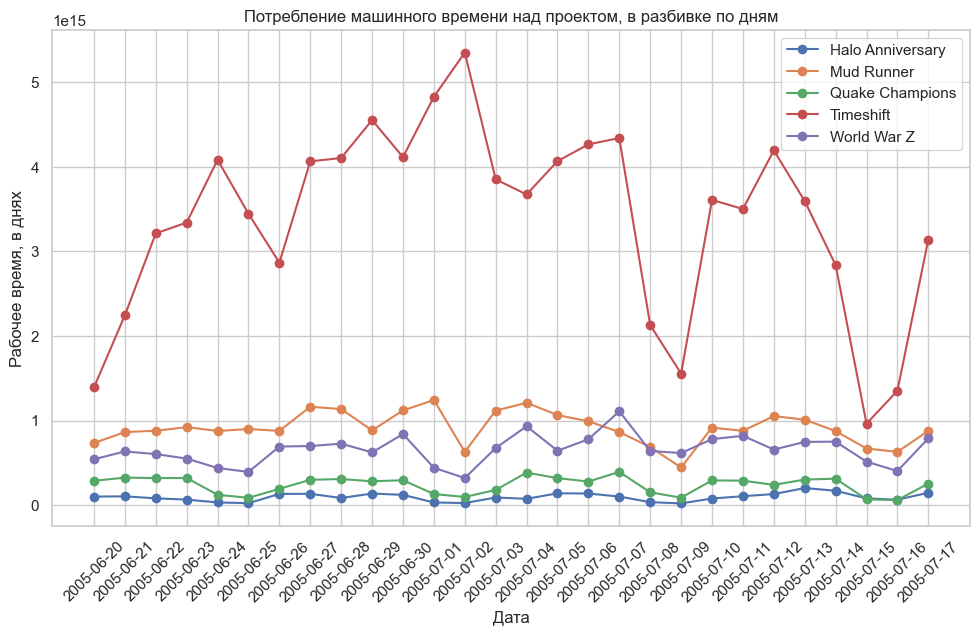

In [212]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for project, group in df_3_graf.groupby('project'):
    plt.plot(group['date'], group['work_time'], marker='o', label=project)

plt.title('Потребление машинного времени над проектом, в разбивке по дням')
plt.xlabel('Дата')
plt.ylabel('Рабочее время, в днях')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

### Задача 4

Рассмотрим *еженедельное* общее потребление ресурсов. На второй неделе можно заметить всплеск нагрузки с ее последующим планомерным снижением.

Проанализируйте предоставленные данные и найдите, с чем связано подобное поведение.

In [348]:
# Для начала проверим действительно ли был всплеск нагрузки и какой
df_4 = df
df_4.groupby(['week_number'], as_index= False).work_time.sum()

,week_number,work_time
0,25,378 days 02:05:33.016000
1,26,517 days 04:27:13.243000
2,27,437 days 10:05:08.459000
3,28,378 days 01:13:38.523000


In [351]:
# Поверим нагрузку по проектам, чтобы определить нагрузка равномерна по всем проектам или есть определенные скачки
df_4 = df
df_4.groupby(['project','week_number'], as_index= False).work_time.sum()

,project,week_number,work_time
0,Halo Anniversary,25,6 days 03:29:40.096000
1,Halo Anniversary,26,7 days 02:59:54.125000
2,Halo Anniversary,27,6 days 17:01:14.851000
3,Halo Anniversary,28,10 days 07:26:41.993000
4,Mud Runner,25,70 days 00:26:34.312000
5,Mud Runner,26,84 days 08:40:11.663000
6,Mud Runner,27,71 days 11:19:38.977000
7,Mud Runner,28,69 days 07:45:32.252000
8,Quake Champions,25,19 days 01:52:49.777000
9,Quake Champions,26,18 days 08:18:17.242000


По полученным данным видно, что скачок был по проекту "Timeshift" по сравнению с предыдщей неделей нагрузка вырасла на 50% (от 238 к 357)

In [352]:
# Посмотрим что за задачи увеличили нагрузку по проекту Timeshift на 26 недели по отношению к 25
import numpy as np
df_4_project_by_Build = df_4[(df_4.project == 'Timeshift') & ((df.week_number == 25) | (df.week_number == 26) )]
df_4_project_by_Build = pd.pivot_table(df_4_project_by_Build, values = 'work_time', index = ['build_name'], columns = 'week_number', aggfunc=np.sum, fill_value=0) \
    .reset_index()
df_4_project_by_Build[25] = pd.to_timedelta(df_4_project_by_Build[25])
df_4_project_by_Build[26] = pd.to_timedelta(df_4_project_by_Build[26])
df_4_project_by_Build['diff'] = df_4_project_by_Build[26] - df_4_project_by_Build[25]
df_4_project_by_Build.sort_values(by = 'diff', ascending = False).head(7)

week_number,build_name,25,26,diff
1,build_cyan_executable,69 days 01:45:18.780000,112 days 03:58:04.445000,43 days 02:12:45.665000
14,build_yellow_sound,16 days 03:50:10.097000,40 days 13:58:42.293000,24 days 10:08:32.196000
46,validate_green_executable,22 days 16:35:57.987000,42 days 03:44:57.318000,19 days 11:08:59.331000
33,test_green_data,7 days 01:51:59.931000,15 days 06:32:31.786000,8 days 04:40:31.855000
43,validate_blue_executable,12 days 06:57:10.665000,20 days 08:27:03.195000,8 days 01:29:52.530000
10,build_red_sound,2 days 15:01:48.729000,9 days 02:34:56.831000,6 days 11:33:08.102000
6,build_green_texture,0 days 00:28:07.554000,4 days 09:19:57.748000,4 days 08:51:50.194000


Итак выше определены задачи, которые создали данную нагрузку на 26 неделе, постараемся найти авторов этих всплесков

In [366]:
# # Посмотрим что за пользователи внутри задач увеличили нагрузку по проекту Timeshift на 26 недели по отношению к 25
df_4_project_by_author = df_4[(df_4.project == 'Timeshift') & ((df.week_number == 25) | (df.week_number == 26) )]
df_4_project_by_author = pd.pivot_table(df_4_project_by_author, values = 'work_time', index = ['build_name', 'author'], columns = 'week_number', aggfunc=np.sum, fill_value=0) \
    .reset_index()
df_4_project_by_author[25] = pd.to_timedelta(df_4_project_by_author[25])
df_4_project_by_author[26] = pd.to_timedelta(df_4_project_by_author[26])
df_4_project_by_author['diff'] = df_4_project_by_author[26] - df_4_project_by_author[25]
df_4_project_by_author['diff, %'] = ((df_4_project_by_author[26] / df_4_project_by_author[25]) *100).round(1)
df_4_project_by_author_final = df_4_project_by_author.sort_values(by = 'diff', ascending = False).head(20)
df_4_project_by_author_final.sort_values(['build_name','diff'], ascending = [False, False])

week_number,build_name,author,25,26,diff,"diff, %"
211,validate_green_executable,Bendy Python,8 days 10:29:36.151000,25 days 22:44:28.300000,17 days 12:14:52.149000,307.5
191,validate_blue_executable,Kenny Xi,0 days 00:10:22.415000,4 days 06:36:50.878000,4 days 06:26:28.463000,59351.2
187,validate_blue_executable,Kenny Ivanov,0 days 15:52:33.751000,2 days 16:52:42.231000,2 days 01:00:08.480000,408.7
145,test_green_data,John Ivanov,0 days 00:00:38.182000,5 days 02:39:11.209000,5 days 02:38:33.027000,1156438.1
141,test_green_data,Bendy Python,0 days 00:00:00,3 days 02:05:49.609000,3 days 02:05:49.609000,inf
103,build_yellow_sound,Marsha Koltron,9 days 12:59:32.986000,23 days 00:03:24.933000,13 days 11:03:51.947000,241.1
92,build_yellow_sound,Eric Smith,1 days 17:47:22.197000,9 days 10:24:17.283000,7 days 16:36:55.086000,541.8
95,build_yellow_sound,John Ivanov,0 days 00:47:18.698000,4 days 14:40:51.923000,4 days 13:53:33.225000,14036.4
81,build_red_sound,John Ivanov,1 days 19:50:36.925000,5 days 12:23:47.925000,3 days 16:33:11,302.0
53,build_cyan_texture,Polly Kotlin,2 days 00:04:13.392000,6 days 06:40:07.302000,4 days 06:35:53.910000,313.4


Вывод: всплеск нагрузки вызван активной работой по проекту Timeshift. 

В ходе проверки по проекту Timeshift были выявлены задачи, которые формируют высокий всплеск нагрузки, а также выявлен конкретный пользователей внутри данных задач.